# CIP-50 Data Analysis and Visualization
CIP-50 | Liesenfelt-Shelleys_Voltaire_decentralization_update Notebook

Author of CIP: Michael Liensenfelt | [github](https://github.com/michael-liesenfelt) | [twitter](https://twitter.com/DrLiesenfelt)

DataViz: Christophe Garant | [github](https://github.com/ccgarant) | [twitter](https://twitter.com/TheStophe)

Date: April 2022

Ref:
1. [CIP-0050? | Liesenfelt Shelleys Voltaire decentralization update](https://github.com/cardano-foundation/CIPs/pull/242)
2. [CIP-0050? | Liesenfelt Shelleys Voltaire decentralization update FULL VERSION](https://github.com/michael-liesenfelt/CIPs/blob/CIP-Liesenfelt-Shelleys_Voltaire_decentralization_update/CIP-Liesenfelt-Shelleys_Voltaire_decentralization_update/README.md)
3. [Cardano Foundations - Cardano Improvement Proposals (CIPs)](https://github.com/cardano-foundation/CIPs)
4. [Garant cip-50 supporting work](https://github.com/ccgarant/cardano-cip-50-draft-liesenfelt-supporting-work)
5. [Design Spec for Delegations and Incentives in Cardano, IOG, July 2020](https://hydra.iohk.io/build/13099669/download/1/delegation_design_spec.pdf)
6. [Reward Sharing Schemes for Stake Pools, Brunjes et al., June 2020](https://arxiv.org/ftp/arxiv/papers/1807/1807.11218.pdf)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Definitions

- $R$ - The total available reward per pool per epoch (in ada).
- $k$ - [0,inf) The desired number of pools
- $a_0$ - [0,inf) The influence of stake pledged by the owners should have on the desirability of the pool. Small values of a0 indicate little influence.
- $\rho$ - [0,1] Rho is the monetary expansion rate, determining the fraction of still available ada that will be created per epoch.
- $\tau$ - [0,1] Tau is the fraction of rewards going to the treasury.
- $\eta$ - Eta is the ratio between the number of blocks produced vs expected in an epoch (i.e. missed blocks lower eta)
- $T_{\infty}$ - The maximal amount of ada to ever be in circulation ($45*10^9$ Ada)
- $T$ - The amount of ada in circulation at the beginning of the epoch for which we want to calculate the rewards pot.
- $fees$ - The transaction fees (tx) in an epoch
- _active stake_ - The amount of stake delgated to active pools.  
- _total stake_ - The total supply of ada, with a % not delegated or in dead pools.

#### Stake Pool Parameters
- $costs, c$ (minFee) - (340+) minimum fee cost for a pool mining a block (min 340 ada)
- $margin, m, \pi$  - (0,1] the pool operator margin or percent % taken from block mining rewards off the top before delegators.
- $pledge, \lambda, s$ - the relative stake of the pool owners, or the amount of ada pledged during pool registration.
- $sigma, \sigma$ - [0,1] the relative stake of the pool, total stake of the pool, relative to the _total stake_, not the active stake. 
    - note: includes the stake s, pledge, or lambda pledged by the pool owners

For instance, if the total supply of ada is T = 31,000,000,000 and the pool owners pledge (s, lambda) is 15,500,000, and the pool attracts 15,500,000 of ada delegation from pool members, then:

$$ \beta = \frac{1}{k} = 1/500 = 0.002 $$
$$ \lambda = \frac{15,500,000}{31,000,000,000} = 0.0005 $$
$$ \sigma = \frac{15,500,000 + 15,500,000}{31,000,000,000} = 0.001 $$

#### Monetary Expansion
The monetary expansion is the expanding circulating supply of ada in a given epoch. Since cardano is based on a fixed total supply, every new epoch issues less new ada, a depreciating new amount issued, just like bitcoin.

$$ \min(\eta,1)*\rho*(T_\infty-T) $$


## Current Reward Formula Exploration
- with sliders to interactively explore
- static examples from cip50 as guided exploration

References:
Using the terminology from [Ref (6)](https://arxiv.org/ftp/arxiv/papers/1807/1807.11218.pdf) Reward Sharing Scheme (RSS) Section 4.1 Our RSS construction, and referencing [Ref (5)](https://hydra.iohk.io/build/13099669/download/1/delegation_design_spec.pdf) delegation_design_spec from IOG, Section 5 Design of Incentives (Specifically 5.5.3 Pool Rewards)

### Formula
The total available rewards per pool per epoch, R, is given by

$$ R = (reserve*\rho+fees)(1-\tau) $$

The reward sharing scheme formula, r, is given by (i.e. rewards per pool)

$$ r_k(\sigma,\lambda) = \frac{R}{1+\alpha} * (\sigma'+\lambda'*\alpha*\frac{\sigma' - \lambda'*\frac{1-\sigma'}{\beta}}{\beta}) $$

Where:
- $R$ is the total rewards per epoch
- $\alpha=a_0$ (0,inf] is the influence of stake pledged by the owners should have (fixed parameter)
- $k$ is the target number of stake pools in the system
- $\sigma' = min\{\sigma,\beta\}$, where $\sigma$ is the total relative stake of the pool to total stake (includes pledge amount)
- $\lambda' = min\{\lambda,\beta\}$, where $\lambda$ is the pool operator pledge stake relative to the total stake.
- $\beta=\frac{1}{k}$ where k is the target number of pools (fixed parameter)

Plugging everything in results in the long form:

$$ r(\sigma,\lambda) = R*\frac{1}{1+\alpha}*\bigg(min\{\sigma,\frac{1}{k}\}+min\{\lambda,\frac{1}{k}\}*\alpha*\frac{min\{\sigma,\frac{1}{k}\}+min\{\lambda,\frac{1}{k}\}*(1-min\{\sigma,\frac{1}{k}\}/(\frac{1}{k}))}{(\frac{1}{k})}\bigg) $$

From Ref (6) Definition 5, Desirability and Potential Profit, the potential profit P of a saturated pool with allocated pool leader stake $\lambda$ and cost $c$ is $P(\lambda,c)=r(\beta,\lambda)-c$

Current Parameters:
- k = 500
- $\alpha$ = a0 = 0.3
- R = 1 for simplicity, r will be a % of the total R rewards
- $costs$ = 340 (or minFee, c) the minimum cost fee for pools
- T = ~34B ada circulating supply per coinmarketcap, epoch 334. 
- Staked = 23B / 34B per pooltool.io (22.06 billion staked) (23B/34B ada staked/circulating supply)
- $margin$ = 0,(or m) assume 0% margin for now on the stake pool (% cut of rewards after costs $c$ per block mined)
- $pledge$ = 10k ada, stake pool pledge amount.

In [2]:
# parameters
k = 500      
alpha = 0.3       #a0
R = 1

# static pool parameters
costs = 340                   #c, pool costs (min 340 per block)
margin = 0                    #[%] pool margin
pledge = 10_000_000           #pool pledge
T_inf = 45*10**9              #45*10^9 total max supply
T = 34*10**9                  #total circulating supply
active_stake = 23*10**9       #percent of circulating supply in active stake pools (some in deap pools, or not staked)
total_stake = T               #circulating supply

# dynamic pool params
stake = np.int8(1)              #[int] place holder type 

# setup equations
beta = 1/k                                           #0.002 (fixed param)
stake = 1                                            #[ada] place holder, (dynamic param)
pool_stake_saturation_limit = total_stake*(1/k)      #about 68M ada, which is correct per adapools.org

sigma_stake = stake/total_stake                      #[%] total stake pool stake relative to total_stake, including pledge lambda
lam_da_stake = pledge/total_stake                    #[%] lambda, but can use that word because it's a built in function

sigma_prime = np.min([sigma_stake,beta])             #lowest between sigma_stake (%) and beta (1/k) (%)
lam_da_prime = np.min([lam_da_stake,beta])           #lowest between lambda_stake (%) and beta (1/k) (%)

In [3]:
def rewards_current_saturation_range(k, alpha, pledge, sat_start, sat_end, total_stake):

    '''
    Function that returns the stake pool rewards given a saturation range and other pool and networks states.
    E.g. what is my expected reward given, k, a0, pledge, and T, over 0% to 200% pool saturation.

    Inputs:
    * k - [int] number of desired stake pools in the network for decentralization
    * alpha - [float] a0, the desired influence stake pool pledge shall have on the network. small a0 is little influence.
    * pledge - [int,ada] lambda, stake pool operating pledge amount
    * sat_start - [float,%] E.g. 0 %, total relative stake of the pool, starting percentage range, includes pledge. e.g. 0 for 0%
    * sat_end - [float,%] E.g. 200 %, total relative stake of the pool, ending percentage range, includes pledge. e.g. 200 for 200%
    * total_stake - [int,ada] the total stake, or circulating that includes active stake and ada not staked or in dead pools

    Outputs:
    * r - [%] rewards in % from 0 to max rewards range
    * sat_range - [%] pool saturation range from sat_start to sat_end

    '''

    ### setup

    #total rewards per epoch, set to 1 for rewards to be a percentage
    R = 1

    #beta, inverse of k ideal pools for simplicity
    beta = 1/k      #[float] (fixed param) inverse of desired number of pools k (k=500, beta = 0.002)

    #pool saturation max [float, ada] (fixed param)
    #about 68M ada to reach max saturation, which is correct per adapools.org
    #checked at epoch 334 total circulating stake is 34 BAda per coinmarketcap (25 April 2022)
    #max pool size is the total stake divided by the ideal number of pools k
    pool_stake_saturation_max = total_stake*(1/k)

    #pool saturation percent range [%] (dynamic param)
    #[%]start, stop, in increments. (stop+increment because starts at 0)
    increment = 0.1             #[%] increment
    sat_start = sat_start/100   #[float] convert from percent to decimal
    sat_end = sat_end/100       #[float] convert from percent to decimal

    #create saturation percent range
    sat_range = np.arange(sat_start,sat_end+increment,increment) #[np_array] e.g. 0, 2.1, 0.1 for 0% to 200% in 10% increments

    # pool saturation range in ada
    # percent range times max ada for fraction of max pool total stake
    sigma_stake_range = sat_range*pool_stake_saturation_max      #[float,ada] frac_ada = % * max_ada

    #total stake pool stake relative to total_stake, including pledge lambda
    sigma_stake = sigma_stake_range/total_stake      #[%, ada/ada]

    #creates beta array of same length of sat_range
    beta_array = np.repeat(beta, len(sat_range))     #[float] 

    #sigma prime
    sigma_p = np.minimum(sigma_stake,beta_array)     #[%] compare two arrays and returns a new array containing the element-wise minima.
    
    #[%] lambda, but can use that word because it's a built in function, so lambdah
    lamdah_stake = pledge/total_stake                #[%, ada/ada] pledge amount relative to total stake   

    #lambda prime
    lambdah_p = np.minimum(lamdah_stake,beta)        #[%] compare two numbers and return the min.

    #current rewards formula, broken down into coefficients
    A = R/(1+alpha)
    B = sigma_p + lambdah_p*alpha/beta
    C = (sigma_p - lambdah_p)
    D = ((1-sigma_p)/beta)
    r = A*(B*((C*D)))

    return sat_range, sigma_stake, sigma_stake_range, beta_array, r, sigma_p, lambdah_p

In [4]:
[sat_range, sigma_stake, sigma_stake_range, beta_array, r, sigma_p, lambdah_p] = \
    rewards_current_saturation_range(k,alpha,pledge,0,200,total_stake)

In [5]:
# test print
print(f'\nbeta_array:\n{beta_array}')
print(f'\nsat_range:\n{sat_range}')
print(f'\nsigma_stake_range:\n{sigma_stake_range}')
print(f'\nsigma_stake:\n{sigma_stake}')
print(f'\nsigma_p:\n{sigma_p}')
print(f'\nlambdah_p:\n{lambdah_p}')
print(f'\ncurrent rewards:\n{r}')
print(f'\npledge %:\n{pledge/pool_stake_saturation_limit*100}')

#data dictionary dataframe
dataDict = {
    'sat_range':sat_range,
    'sigma_stake_range':sigma_stake_range,
    'sigma_stake':sigma_stake,
    'beta_array':beta_array,
    'sigma_p':sigma_p,
    'r':r
}

#create dataframe
df = pd.DataFrame(dataDict)


beta_array:
[0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002]

sat_range:
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]

sigma_stake_range:
[0.000e+00 6.800e+06 1.360e+07 2.040e+07 2.720e+07 3.400e+07 4.080e+07
 4.760e+07 5.440e+07 6.120e+07 6.800e+07 7.480e+07 8.160e+07 8.840e+07
 9.520e+07 1.020e+08 1.088e+08 1.156e+08 1.224e+08 1.292e+08 1.360e+08]

sigma_stake:
[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002  0.0022 0.0024 0.0026 0.0028 0.003  0.0032 0.0034 0.0036 0.0038
 0.004 ]

sigma_p:
[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
 0.002 ]

lambdah_p:
0.0002941176470588235

current rewards:
[-0.00499068 -0.00160394  0.00181221  0.00525774  0.00873264  0.01223689
  0.01577046  0.01933334  0.02292552  0.02654697  0.03019767  0.03019767
  

<AxesSubplot:title={'center':'current rewards'}, xlabel='sat_range'>

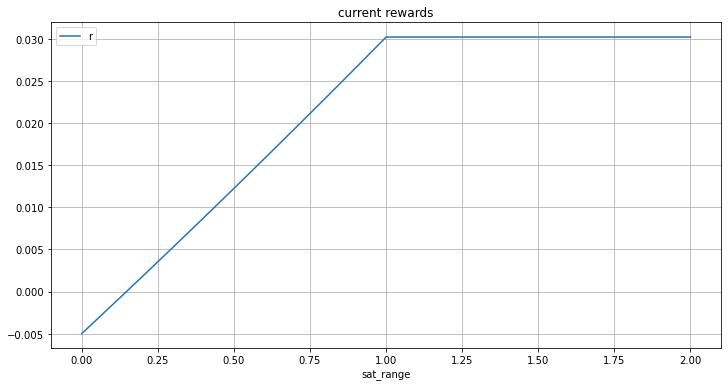

In [6]:
#plots
df.plot('sat_range','r',grid='minor',figsize=(12,6),title='current rewards')

## New Reward Formula Exploration
- with sliders to interactively explore
- static examples from cip50 as guided exploration

## Stake Pools Landscape
Compare contrast individual stake pool then grouped stake pools to highlight k-effective
- delegation amount total bar graph (see big tail)
	- color code top 500? top k-effective? top Nakamoto coefficient?
- stake vs leverage
	- color code top 500? color code for groups? sSPO alliances?
	- prove point of small mSPO vs big private pools.
- time history of stake pools and sizes video (ref: https://youtu.be/hVimVzgtD6w?t=706)

## Private vs Public Stake Pools
- what % are private vs public
- what do they look like, a0 and k?

## Computational Efficiency
 - compare contrast current vs proposed timeit w/ stress test.